<h3>10.2 特征提取</h3>

特征提取示意图
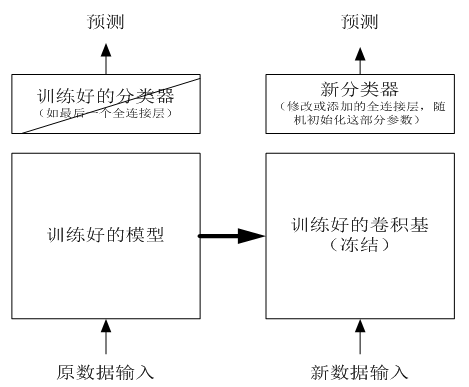

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from datetime import datetime

In [2]:
trans_train = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),     
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=trans_valid)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


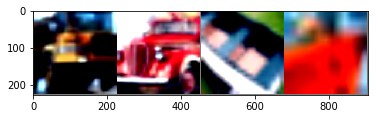

truck truck  ship  ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()


# 显示图像
imshow(torchvision.utils.make_grid(images[:4]))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# 使用预训练的模型
net = models.resnet18(pretrained=True)

In [5]:
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

In [6]:
# 将最后的全连接层改成十分类
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net.fc = nn.Linear(512, 10)
#net = torch.nn.DataParallel(net)



In [7]:
# 查看总参数及训练参数
total_params = sum(p.numel() for p in net.parameters())
print('总参数个数:{}'.format(total_params))
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('需训练参数个数:{}'.format(total_trainable_params))


总参数个数:11181642
需训练参数个数:5130


In [8]:
net=net.to(device)

In [9]:
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


In [10]:
criterion = nn.CrossEntropyLoss()
#只需要优化最后一层参数
optimizer = torch.optim.SGD(net.fc.parameters(), lr=1e-3, weight_decay=1e-3,momentum=0.9)


In [11]:
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
   
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device) # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device) # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [12]:
train(net, trainloader, testloader, 20, optimizer, criterion)

Epoch 0. Train Loss: 1.470662, Train Acc: 0.501299, Valid Loss: 0.913619, Valid Acc: 0.704120, Time 00:02:45
Epoch 1. Train Loss: 1.218964, Train Acc: 0.579264, Valid Loss: 0.821985, Valid Acc: 0.726214, Time 00:03:19
Epoch 2. Train Loss: 1.176578, Train Acc: 0.592571, Valid Loss: 0.788861, Valid Acc: 0.736664, Time 00:03:19
Epoch 3. Train Loss: 1.154606, Train Acc: 0.597706, Valid Loss: 0.779969, Valid Acc: 0.735271, Time 00:03:19
Epoch 4. Train Loss: 1.144575, Train Acc: 0.602402, Valid Loss: 0.750391, Valid Acc: 0.748308, Time 00:03:19
Epoch 5. Train Loss: 1.135708, Train Acc: 0.601183, Valid Loss: 0.754318, Valid Acc: 0.745123, Time 00:03:20
Epoch 6. Train Loss: 1.128625, Train Acc: 0.605738, Valid Loss: 0.748776, Valid Acc: 0.748905, Time 00:03:21
Epoch 7. Train Loss: 1.121514, Train Acc: 0.607956, Valid Loss: 0.738947, Valid Acc: 0.746517, Time 00:03:22
Epoch 8. Train Loss: 1.125171, Train Acc: 0.608636, Valid Loss: 0.731027, Valid Acc: 0.749900, Time 00:03:22
Epoch 9. Train Loss

<h3>10.3 数据增强</h3>

In [17]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

(600, 600, 3)

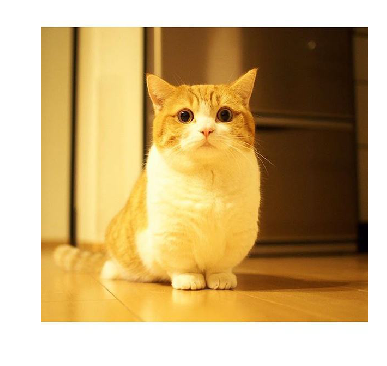

In [37]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open('/home/wumg/data/image/cat/cat.jpg')
np.array(x).shape
imshow(x)

In [28]:
def imshow_tensor(image, ax=None, title=None):
    """可视化张量(Tensor)"""

    if ax is None:
        fig, ax = plt.subplots()

    # 把第3个维度设置为颜色通道
    image = image.numpy().transpose((1, 2, 0))

    # 反转预处理步骤
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # 剪切图像像素值
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [60]:
import sys

from PIL import Image
from torchvision import transforms as trans

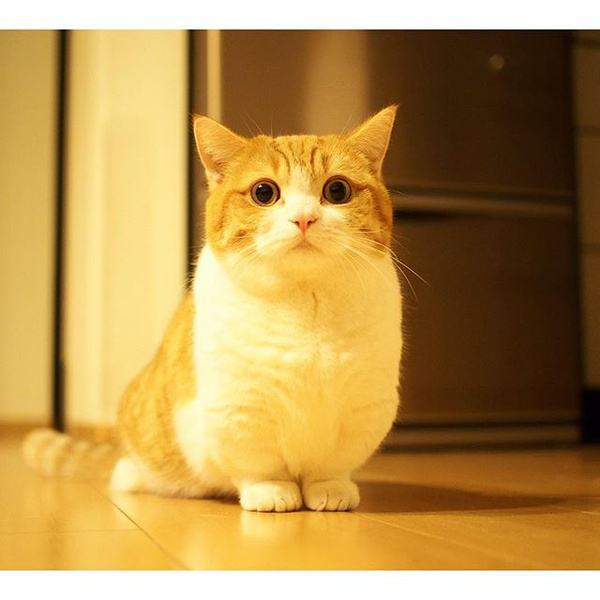

In [59]:
# 读入一张图片
im = Image.open('./image/cat/cat.jpg')
im

原图片大小: (600, 600)
缩放后大小: (200, 100)


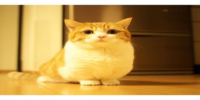

In [61]:
#随机比例缩放主要使用的是 torchvision.transforms.Resize()
# 比例缩放
print('原图片大小: {}'.format(im.size))
new_im = trans.Resize((100, 200))(im)
print('缩放后大小: {}'.format(new_im.size))
new_im


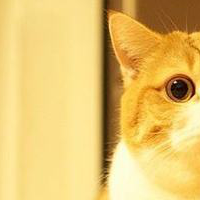

In [70]:
#随机位置截取能够提取出图片中局部的信息，使得网络接受的输入具有多尺度的特征，所以能够有较好的效果。
#在 torchvision 中主要有下面两种方式，一个是 torchvision.transforms.RandomCrop()，
#传入的参数就是截取出的图片的长和宽，对图片在随机位置进行截取；第二个是 torchvision.transforms.CenterCrop()，
#同样传入介曲初的图片的大小作为参数，会在图片的中心进行截取
# 随机裁剪出 100 x 100 的区域
random_im1 = trans.RandomCrop(200)(im)
random_im1

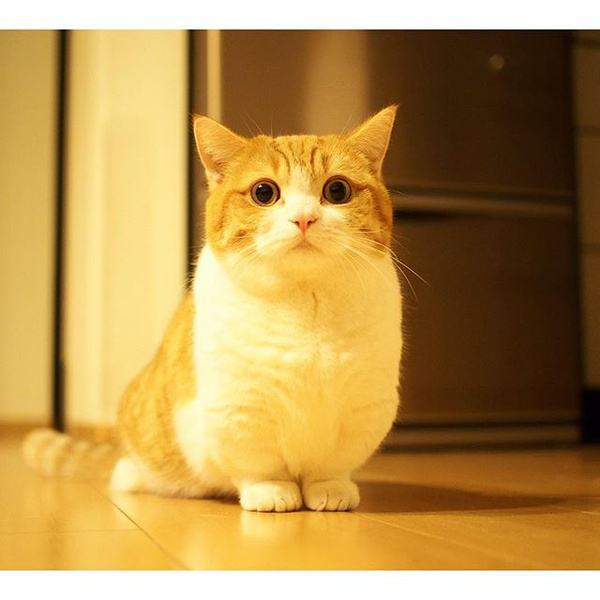

In [76]:
#我们将它翻转一下，它仍然是一张猫，但是图片就有了更多的多样性，所以随机翻转也是一种非常有效的手段。
#在 torchvision 中，随机翻转使用的是 torchvision.transforms.RandomHorizontalFlip() 
#和 torchvision.transforms.RandomVerticalFlip()
# 随机水平翻转
h_filp = trans.RandomHorizontalFlip()(im)
h_filp


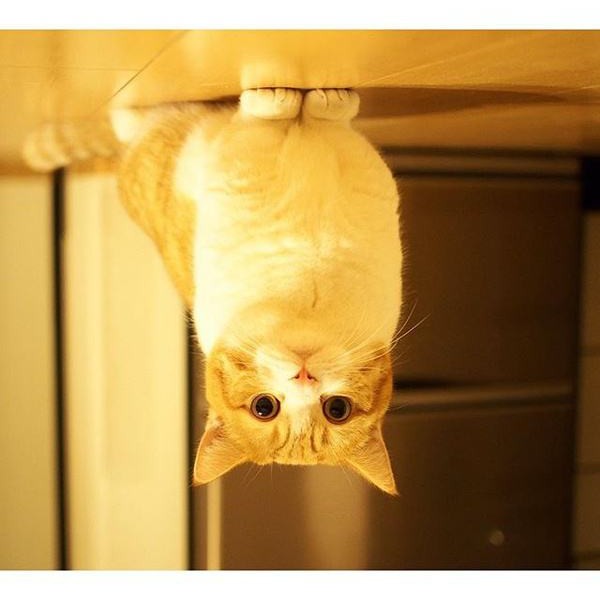

In [77]:
# 随机竖直翻转
v_flip = trans.RandomVerticalFlip()(im)
v_flip

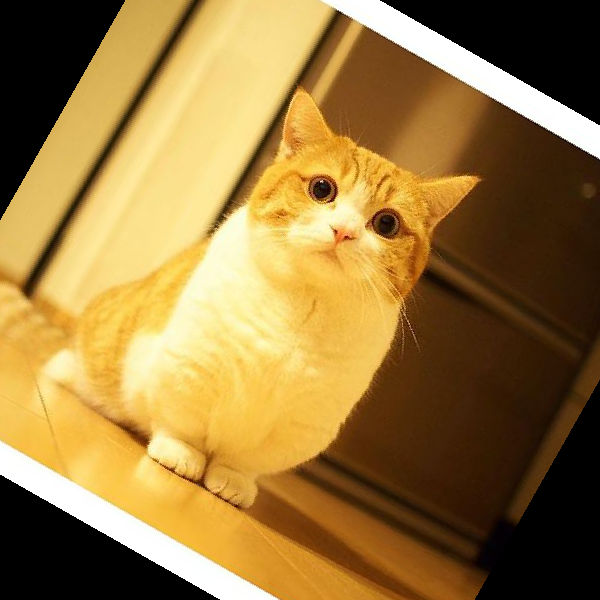

In [48]:
#一些角度的旋转仍然是非常有用的数据增强方式，在 torchvision 中，
#使用 torchvision.transforms.RandomRotation() 来实现
rot_im = tfs.RandomRotation(45)(im)
rot_im

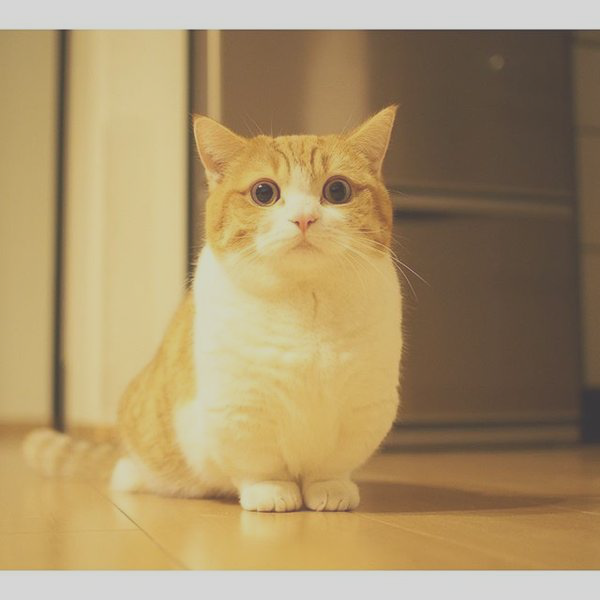

In [52]:
#除了形状变化外，颜色变化又是另外一种增强方式，其中可以设置亮度变化，对比度变化和颜色变化等，
#在 torchvision 中主要使用 torchvision.transforms.ColorJitter() 来实现的，第一个参数就是亮度的比例，
#第二个是对比度，第三个是饱和度，第四个是颜色
# 对比度
contrast_im = tfs.ColorJitter(contrast=1)(im) # 随机从 0 ~ 2 之间对比度变化，1 表示原图
contrast_im


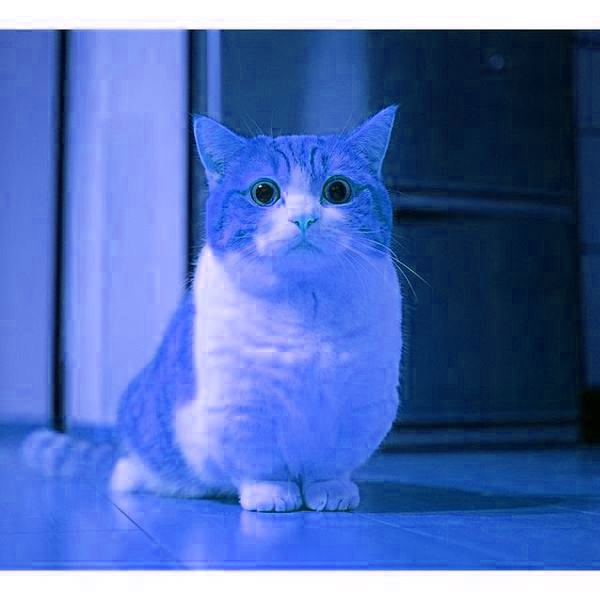

In [78]:
# 颜色
color_im = trans.ColorJitter(hue=0.5)(im) # 随机从 -0.5 ~ 0.5 之间对颜色变化
color_im

In [79]:
im_aug = trans.Compose([
    tfs.Resize(200),
    tfs.RandomHorizontalFlip(),
    tfs.RandomCrop(96),
    tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5)
])


(0.0, 1.0, 0.0, 1.0)

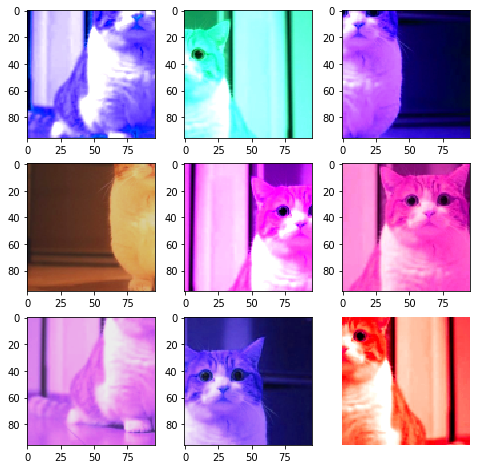

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
nrows = 3
ncols = 3
figsize = (8, 8)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
plt.axis('off')
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(im_aug(im))
plt.show()
